# Churn of clients forecast 

### The task description

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

# Work plan

To acomplish the the task, we will follow the next plan:
1. Prepare the data.
2. Conduct EDA.
3. Prepare the data for learning. We will use the following machine learning models: Dummy Model as a baseline, Decision Tree, Random Forest, CatBoost, and LightGBM. For Decision Tree and Random Forest, we will encode the data with One-Hot Encoding. Next, we will split the data (both encoded and the original) into train and test sets. Then we will upsample the training sets to address the class imbalance. And finally, we will scale the data.
4. Train models. We will train the above-mentioned models with parameter tuning. And then we will select the model with the best score.
5. Finally, we will test the best model on the test data set.

# Contents 
* [Data overview]()
* [Data preprocessing]()
* [Exploratory Data Analysis]()
* [Model Training]()
* [Final testing]()
* [Solution Report]()

# Data overview

First of all, will load the data and the libraries that we will use in this project.

In [1]:
# Loading all required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
# Loading the data files into DataFrames
contract=pd.read_csv('C:\jupyter_notebook\contract.csv')
phone=pd.read_csv('C:\jupyter_notebook\phone.csv')
internet=pd.read_csv('C:\jupyter_notebook\internet.csv')
personal=pd.read_csv('C:\jupyter_notebook\personal.csv')

We will display general data info and a sample of the data.

### Contract

In [3]:
# printing the general/summary information about the contract DF
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
#printing a sample of data
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


There are no missing values, but some columns are in incorrect format and some data preprocessing is required. `EndDate` is a target column, there `No` shows that the customer did not leave. We will replace 'No' values with 0 and other values with 1. 

In terms of the prediction model, instead of `BeginDate`, it is more useful to calculate how many days the customer was with the company.

Also, we will change the `Type`, `PaperlessBilling`, and `PaymentMethod` column types to category. `Total charges` has an incorrect type and need to be changed to float.

### Phone

In [5]:
# printing the general/summary information about the phone DF
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [6]:
#printing a sample of data
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


There are no missing values. Apart from `customerID`, there is only one column which type we will change to category. Let’s just confirm that there are only 2 categories.

In [7]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

There are only two categories. 

Also, there are fewer rows than in the contract table, which means that not all customers use phone service.

### Internet

In [8]:
# printing the general/summary information about the internet DF
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
#printing a sample of data
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


There are also no missing values. Also, judging by the number of rows, not all customers use internet service. For all columns (apart from `customerID`) we will change column types to categories.

### Personal

In [10]:
# printing the general/summary information about the personal DF
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
#printing a sample of data
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


There are no missing values and the number of rows matches the number of rows in the `contract` table, which is great. For all columns (apart from customerID) we will change column types to categories.

# Data preprocessing

At this step, we will preprocess the data as described in `Data overview section. We also will merge the data into one table.

### Contract

First of all, we will add the target `churn` column based on the `BeginDate` column.

In [12]:
#adding churn column
contract['churn']=contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)

Next, we will add the `days` column that will show how many days the customer stayed with the company. We will calculate days as the difference between `EndDate` and `BeginDate`. For `EndDate` where values are equal to 'No', we will use the data to which the contract information is valid as of - February 1, 2020.

In [13]:
#replacing No in EndDate column with February 1, 2020
contract['EndDate']=contract['EndDate'].replace('No','2020-02-01 00:00:00')

#convirting BeginDate and EndDate columns type to DateTime
contract['BeginDate']=pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate']=pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S')

#adding days column 
contract['days']=(contract['EndDate'] - contract['BeginDate']).dt.days

Also, we will change `Type`, `PaperlessBilling`, and `PaymentMethod` column types to category and `Total charges` to float.

In [14]:
#changing Type, PaperlessBilling, and PaymentMethod column types to category
contract['Type']=contract['Type'].astype('category')
contract['PaperlessBilling']=contract['PaperlessBilling'].astype('category')
contract['PaymentMethod']=contract['PaymentMethod'].astype('category')

#changing column types of Total charges to float
contract['TotalCharges']=pd.to_numeric(contract['TotalCharges'], errors='coerce')

Let’s check the general table info after the changes.

In [15]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   churn             7043 non-null   int64         
 9   days              7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 406.4+ KB


As can be seen values in the `TotalCharges` column for a few rows become null. Let’s check these rows.

In [16]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


These customers are just joined, and this is why there are no TotalCharges for them. So, we will fill them with 0.

In [17]:
#filling null in TotalCharges column with 0
contract['TotalCharges']=contract['TotalCharges'].fillna(0)

Finally, for this table, we will drop the `BeginDate` and `EndDate` columns as we don’t need them anymore.

In [18]:
# dropping the BeginDate and EndDate columns
contract=contract.drop(['BeginDate', 'EndDate'], axis=1)

In [19]:
#confirming that contract DF is good now
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Type              7043 non-null   category
 2   PaperlessBilling  7043 non-null   category
 3   PaymentMethod     7043 non-null   category
 4   MonthlyCharges    7043 non-null   float64 
 5   TotalCharges      7043 non-null   float64 
 6   churn             7043 non-null   int64   
 7   days              7043 non-null   int64   
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 296.3+ KB


### Personal

As proposed for all columns (apart from customerID) we will change column types to categories. Then we will merge the `contract` and `personal` tables.

In [20]:
#changing column types to category
personal['gender']=personal['gender'].astype('category')
personal['Partner'] = personal['Partner'].astype("category")
personal['Dependents'] = personal['Dependents'].astype("category")
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype("category")

In [21]:
#copying contract table to a new table
contract_full=contract

#merging personal table to contract_full table
contract_full=pd.merge(contract_full, personal, how="left", on="customerID")

In [22]:
#confirming that the merged table look correct
print(contract_full.info())
contract_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Type              7043 non-null   category
 2   PaperlessBilling  7043 non-null   category
 3   PaymentMethod     7043 non-null   category
 4   MonthlyCharges    7043 non-null   float64 
 5   TotalCharges      7043 non-null   float64 
 6   churn             7043 non-null   int64   
 7   days              7043 non-null   int64   
 8   gender            7043 non-null   category
 9   SeniorCitizen     7043 non-null   category
 10  Partner           7043 non-null   category
 11  Dependents        7043 non-null   category
dtypes: category(7), float64(2), int64(2), object(1)
memory usage: 379.2+ KB
None


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No


### Phone

As not every customer has a phone plan, we will merge the phone table first. Then we will fill the missing values with 'NoService' values and the merged column type to the category.

In [23]:
#merging phone table to contract_full table
contract_full=pd.merge(contract_full, phone, how="left", on="customerID")

#filling missing values with 'NoService' 
contract_full['MultipleLines']=contract_full['MultipleLines'].fillna('NoService')

#changing column types to category
contract_full['MultipleLines']=contract_full['MultipleLines'].astype("category")

In [24]:
#confirming that the merged table look correct
print(contract_full.info())
print(contract_full['MultipleLines'].value_counts())
contract_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Type              7043 non-null   category
 2   PaperlessBilling  7043 non-null   category
 3   PaymentMethod     7043 non-null   category
 4   MonthlyCharges    7043 non-null   float64 
 5   TotalCharges      7043 non-null   float64 
 6   churn             7043 non-null   int64   
 7   days              7043 non-null   int64   
 8   gender            7043 non-null   category
 9   SeniorCitizen     7043 non-null   category
 10  Partner           7043 non-null   category
 11  Dependents        7043 non-null   category
 12  MultipleLines     7043 non-null   category
dtypes: category(8), float64(2), int64(2), object(1)
memory usage: 386.2+ KB
None
No           3390
Yes          2971
NoService     682
Name: MultipleLines, dtype: int64


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,NoService
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,NoService
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,No


### Internet

The same as with the `phone` table, we will merge the `internet` table first. Then we will fill the missing values in merged columns with `No` values. Finally, we will change the merged columns type to category. As well, we will drop `customerID`, as we no longer need it.

In [25]:
#merging internet table to contract_full table
contract_full=pd.merge(contract_full, internet, how="left", on="customerID")

#filling missing values
contract_full[internet.columns]=contract_full[internet.columns].fillna('No')

#changing column types to category
contract_full['InternetService']=contract_full['InternetService'].astype("category")
contract_full['OnlineSecurity']=contract_full['OnlineSecurity'].astype("category")
contract_full['OnlineBackup']=contract_full['OnlineBackup'].astype("category")
contract_full['DeviceProtection']=contract_full['DeviceProtection'].astype("category")
contract_full['TechSupport']=contract_full['TechSupport'].astype("category")
contract_full['StreamingTV']=contract_full['StreamingTV'].astype("category")
contract_full['StreamingMovies']=contract_full['StreamingMovies'].astype("category")

#dropping customerID
contract_full=contract_full.drop(['customerID'], axis=1)

In [26]:
#confirming that the merged table look correct
print(contract_full.info())
contract_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   churn             7043 non-null   int64   
 6   days              7043 non-null   int64   
 7   gender            7043 non-null   category
 8   SeniorCitizen     7043 non-null   category
 9   Partner           7043 non-null   category
 10  Dependents        7043 non-null   category
 11  MultipleLines     7043 non-null   category
 12  InternetService   7043 non-null   category
 13  OnlineSecurity    7043 non-null   category
 14  OnlineBackup      7043 non-null   category
 15  DeviceProtection  7043 non-null   category
 16  TechSupport       7043 n

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,NoService,DSL,No,Yes,No,No,No,No
1,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,NoService,DSL,Yes,No,Yes,Yes,No,No
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


# Exploratory Data Analysis

First of all, let’s check if the classes of the target are balanced.

In [27]:
#culculating persentage of calsses
left=len(contract_full[contract_full['churn']==1])/len(contract_full)
stay=len(contract_full[contract_full['churn']==0])/len(contract_full)
print(f'Percnt of customers who left {left}')
print(f'Percnt of customers who stay {stay}')

Percnt of customers who left 0.2653698707936959
Percnt of customers who stay 0.7346301292063041


As can be seen, there are almost 3 times more customers who stay with the company than those who left. So, the classes are imbalanced.

Next, we will create plots to see how the target is dependent on `feature` characteristics.

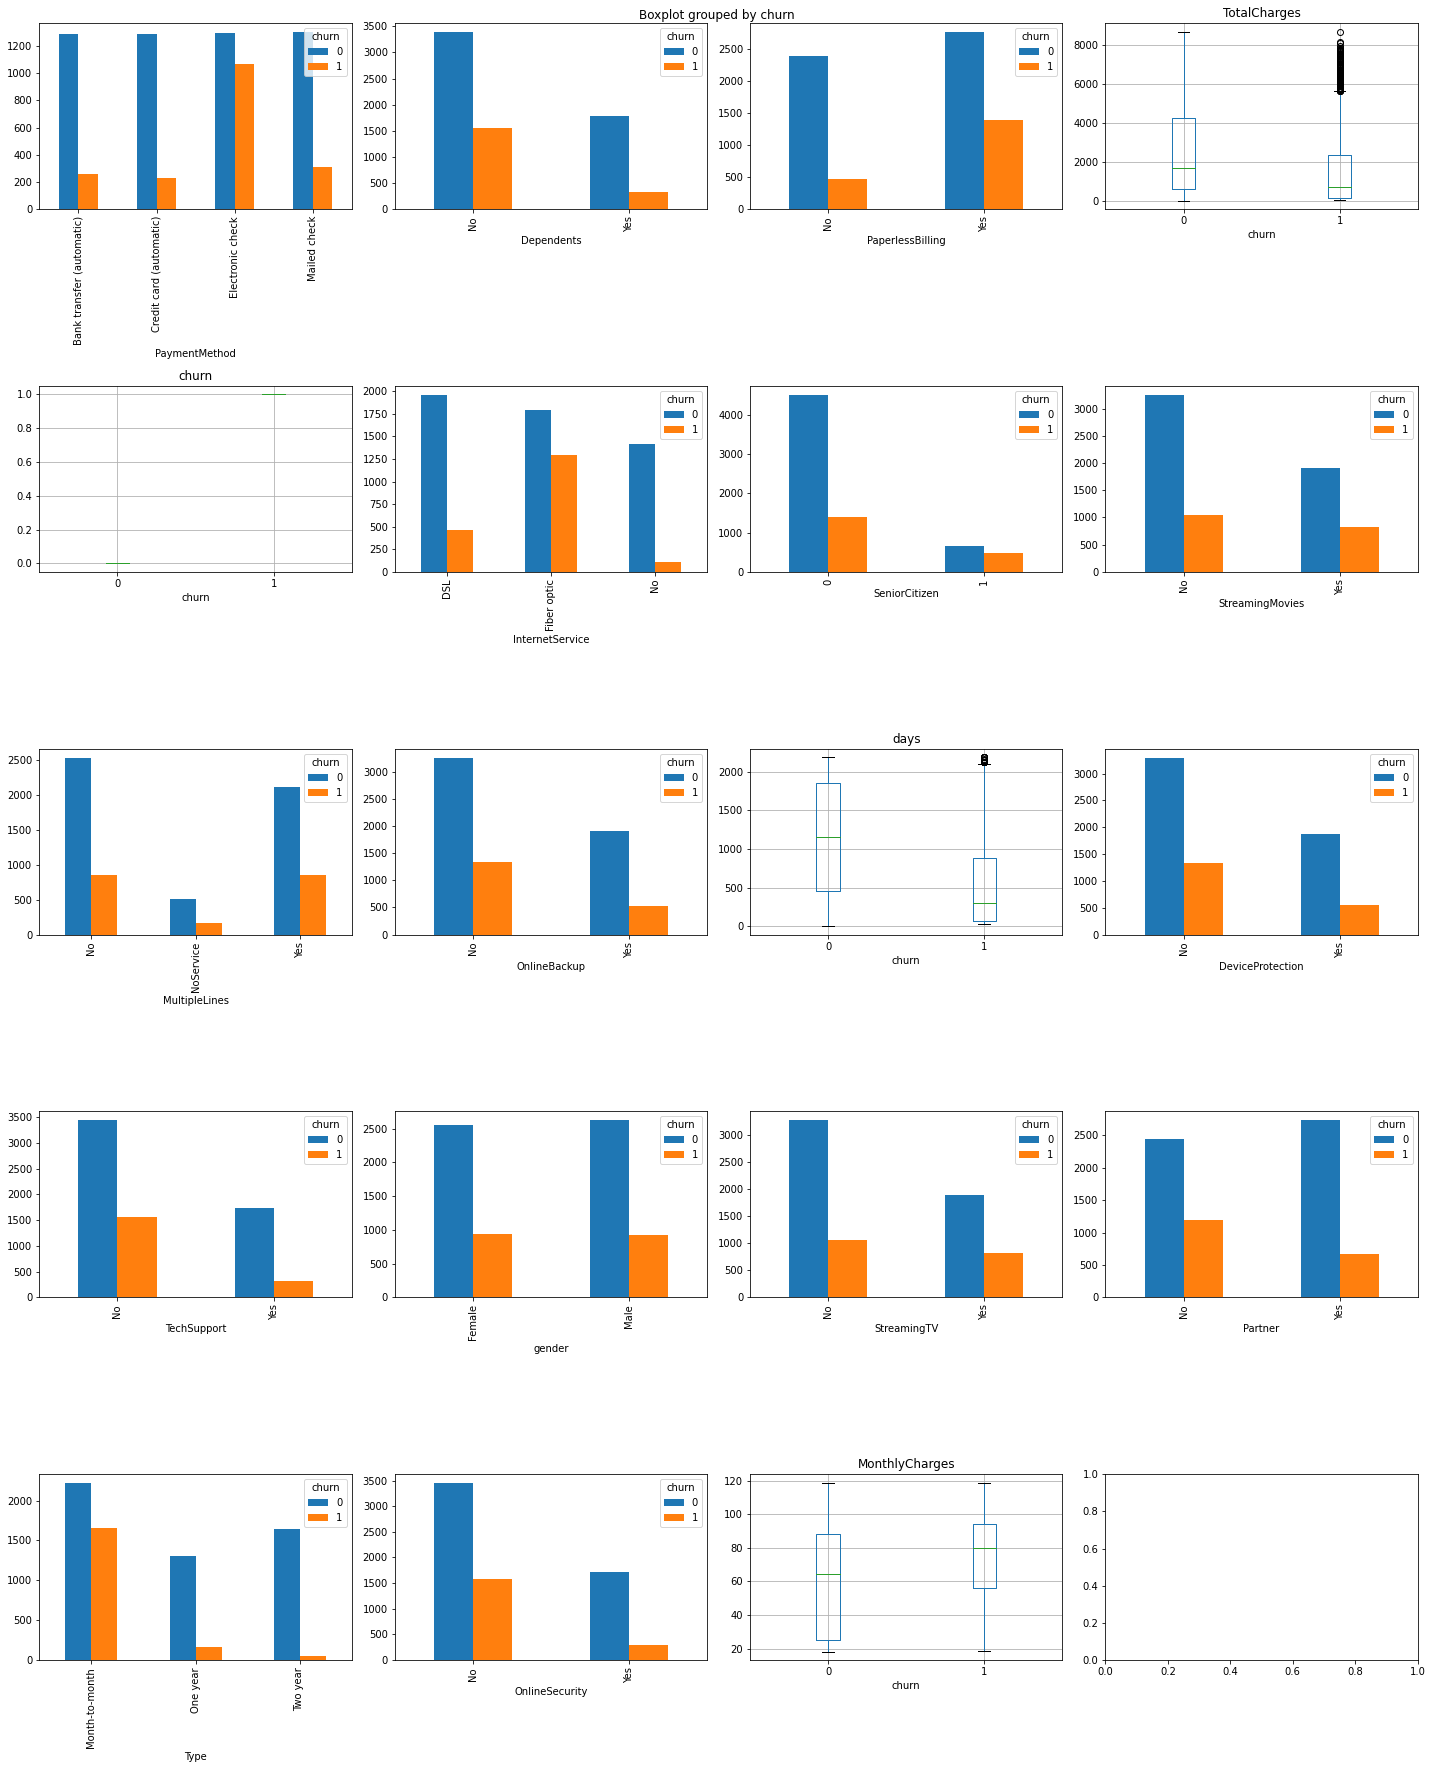

In [28]:
#creating plots
fig, axis = plt.subplots( 5, 4, figsize=(20,25))
axis = axis.flatten()
columns=list(set(contract_full.columns))
for col, axs in zip(columns, axis):

#creating boxplots for numerical features
    if contract_full[col].dtype=='float64' or contract_full[col].dtype=='int64':
        contract_full.boxplot(column=col, by='churn', ax=axs)  
        
#creating barcharts for categorical features
    else:
        feature = contract_full.groupby([col, 'churn'])['churn'].count().unstack()
        feature.plot(kind='bar', stacked=False, label='#churn (neg, pos)', ax=axs)      
plt.tight_layout()
plt.show() 


The following can be seen from the plots:
1. Percentage of the customers who left is less among those who use protection services and have technical support. Probably those customers are happier with their services.
2. Percentage of the customers who left is higher among those who use streaming services. Probably this is due to higher charges. This assumption also can be confirmed by the observation that the monthly charges of those who left are higher.
3. Percentage of the customers who left is higher among those who do not have partners and dependants. Probably those customers are more flexible and do not rely on others when changing the service.
4. Percentage of the customers who left is significantly higher among senior citizens. Probably those customers have less income and may face difficulties with service payments.
5. Percentage of the customers who left is significantly higher among those who use Fiber Optic internet service. Probably this is also due to the higher cost of this service in comparison with DSL.
6. Percentage of the customers who left is significantly higher among those who have a month-to-month payment type. This is expected as this is more difficult to leave a yearly contract as this involves additional charges. In addition, payments on a yearly contract may be less.

Many factors indicate that higher monthly charges may be one of the key reasons why customers left. Let’s explore in more detail the monthly charges for those who left and those who stay.

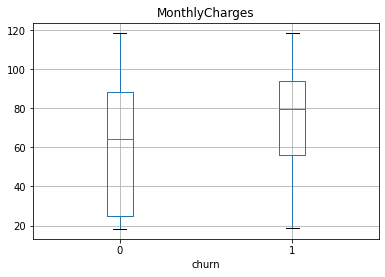

In [29]:
#creating boxplot for MonthlyCharges
contract_full.boxplot(column='MonthlyCharges', by='churn')
plt.suptitle('')
plt.show()

In [30]:
#describing MonthlyCharges for those who left
contract_full[contract_full['churn']==1]['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [31]:
#describing MonthlyCharges for those who stay
contract_full[contract_full['churn']==0]['MonthlyCharges'].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

As can be seen, indeed those who left on average pay more than those who stay.

From the EDA where can be seen a correlation between the target and features attributes, so we should be able to effectively predict with a machine learning model when a customer is about to leave.

# Model Training

## Data encoding

For Decision Tree and Random Forest models, we need to encode the data. We will use One-Hot Encoding.

In [32]:
#creating a copy of the dataset an dencoding it
contract_full_encoded=pd.get_dummies(contract_full, drop_first=True)

In [33]:
#cheching a sample of encoded data
contract_full_encoded.head()

,MonthlyCharges,TotalCharges,churn,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,MultipleLines_NoService,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,29.85,29.85,0,31,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,56.95,1889.50,0,1036,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,61,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,0,0
3,42.30,1840.75,0,1371,1,0,0,0,0,0,...,1,0,0,0,1,0,1,1,0,0
4,70.70,151.65,1,61,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


## Splitting the data

Next, we will split the data (both encoded and the original) into train and test sets.

In [34]:
#splitting not encoded dataset
features=contract_full.drop('churn', axis=1)
target=contract_full['churn']
features_train, features_test, target_train, target_test=train_test_split(features, target, test_size=0.25, random_state=12345)

#splitting encoded dataset
features=contract_full_encoded.drop('churn', axis=1)
target=contract_full_encoded['churn']
features_train_enc, features_test_enc, target_train_enc, target_test_enc=train_test_split(features, target, test_size=0.25, random_state=12345)

In [35]:
#checking sizes of test and train sets
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)
print(features_train_enc.shape)
print(features_test_enc.shape)
print(target_train_enc.shape)
print(target_test_enc.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)
(5282, 23)
(1761, 23)
(5282,)
(1761,)


Sizes of the data sets look correct.

## Data upsampling

At this step, we will upsample the training sets to address the class imbalance. Since we need to perform upsampling for different datasets, we will define the function for upsampling to avoid repetition.

In [36]:
#defining the function to upsample imbalanced class.
def upsample(features, target, repeat):
    
#splitting feature and target into subset with different classes
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

#upsampling imbalanced class and concatinating the classes back together
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

#shuffling the sets
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

#returning the new balanced target and feature sets
    return features_upsampled, target_upsampled

In [37]:
#using the function to upsample the training sets
features_train, target_train = upsample(features_train, target_train, 3)
features_train_enc, target_train_enc = upsample(features_train_enc, target_train_enc, 3)

In [38]:
#checking sizes of train sets after upsampling
print(features_train.shape)
print(target_train.shape)
print(features_train_enc.shape)
print(target_train_enc.shape)

(8072, 18)
(8072,)
(8072, 23)
(8072,)


The sizes of upsampled data sets look correct.

## Data scaling

As a final step before models training, we will scale the data.

In [39]:
#scaling numerical features
pd.options.mode.chained_assignment = None
numeric = ['MonthlyCharges', 'TotalCharges', 'days']
scaler = StandardScaler()

#scaling not encoded dataset
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

#scaling encoded dataset
scaler.fit(features_train_enc[numeric])
features_train_enc[numeric]=scaler.transform(features_train_enc[numeric])
features_test_enc[numeric]=scaler.transform(features_test_enc[numeric])

In [40]:
#printing sample of features train scaled not encoded dataset
features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
498,Month-to-month,No,Electronic check,-1.384093,-0.874994,-0.943089,Female,1,No,No,NoService,DSL,No,Yes,No,No,No,No
6152,Month-to-month,Yes,Credit card (automatic),0.870217,-0.213229,-0.482848,Female,0,No,No,No,Fiber optic,No,Yes,Yes,No,No,Yes
2391,Month-to-month,Yes,Electronic check,-0.311773,-0.734834,-0.816694,Male,0,No,No,Yes,DSL,No,No,No,No,Yes,No
1863,One year,No,Mailed check,-1.500725,-0.856669,-0.900499,Male,0,Yes,No,Yes,No,No,No,No,No,No,No
6596,One year,No,Electronic check,0.454171,1.618811,1.524353,Male,0,No,No,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No


In [41]:
#printing sample of features train scaled encoded dataset
features_train_enc.head()

,MonthlyCharges,TotalCharges,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,MultipleLines_NoService,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
498,-1.384093,-0.874994,-0.943089,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
6152,0.870217,-0.213229,-0.482848,0,0,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,1
2391,-0.311773,-0.734834,-0.816694,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
1863,-1.500725,-0.856669,-0.900499,1,0,0,0,0,1,1,...,0,1,0,1,0,0,0,0,0,0
6596,0.454171,1.618811,1.524353,1,0,0,0,1,0,1,...,0,1,0,0,1,1,1,1,1,0


Now, we can proceed with models training.

## Training models

At this stage, we will train models with parameter tuning. And then we will select the model with the best score. We will use AUC-ROC as the primary metric. We also will use Accuracy as an additional metric for the final testing.

### Dummy Regressor

As a baseline, we will start with the DummyRegressor model that always predicts that customers will stay. Since the dummy model always returns only one class, the ROC AUC score cannot be calculated, so we will calculate only accuracy.

In [42]:
#training dummy model that always predicts that customer will stay
model_dummy=DummyRegressor(strategy='constant', constant=0)
model_dummy.fit(features_test, target_test)
pred=model_dummy.predict(features_test)

#printing score of the dummy model
#since dummy model always return nly one class ROC AUC score cannot be culculated, so we will culculate accuracy
accuracy_score(pred, target_test)

0.7308347529812607

As expected, the accuracy of our dummy model is equal to the percentage of the customers who stay with the company.

### Decision tree

Next with will train different Decision tree models with max_depth parameters in a range from 2 to 50.

In [43]:
#training Decision Tree models and tuning parametrs
model_dt = DecisionTreeClassifier()

#defining parameters for grid search
param={ 'max_depth': range(2,50),
        'random_state': [12345]}

#finding the best parameters and score
grid=GridSearchCV(estimator=model_dt, param_grid=param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
grid.fit(features_train_enc, target_train_enc)
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'max_depth': 23, 'random_state': 12345}
Best score: 0.9097626512268413


The score of the model is quite good. Let's check if we can get a better result with other models.

### Random forest

For Random forest, with will use max_depth equal to the max_depth of the best Decision tree model. We also will tune the n_estimators parameter in the range from 2 to 50.

In [44]:
#training Decision Tree models and tuning parametrs
model_rf = RandomForestClassifier()

#defining parameters for grid search
param={ 'max_depth': [23],
        'n_estimators' : range(2,50),
        'random_state': [12345]}

#finding the best parameters and score
grid=GridSearchCV(estimator=model_rf, param_grid=param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
grid.fit(features_train_enc, target_train_enc)
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'max_depth': 23, 'n_estimators': 45, 'random_state': 12345}
Best score: 0.9818548880701631


The score of the model is even better. Let's check if we can get even a better result with gradient boosting models.

### CatBoost

For the CatBoost model will tune learning_rate parameter.

In [45]:
#training CatBoost models and tuning parametrs
model_cb=CatBoostClassifier()

#defining features that needs to be encoded
features_to_encode=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 
'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
'TechSupport', 'StreamingTV', 'StreamingMovies']

#defining parameters for grid search
param={ 
        'learning_rate': [0.01, 0.05, 0.1, 0.5],    
        'loss_function': ['Logloss'],
        'random_seed': [12345]}

#finding the best parameters
grid=GridSearchCV(estimator=model_cb, param_grid=param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
grid.fit(features_train, target_train, cat_features=features_to_encode, verbose=False)
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'learning_rate': 0.5, 'loss_function': 'Logloss', 'random_seed': 12345}
Best score: 0.9823569224514577


The score of this model is just slightly better than for the Random forest model, but we should not forget that Random forest models usually tend to overfitting.

### LightGBM

Finally, we will train the LightGBM model. The same as for CatBoost, we will tune the learning_rate parameter.

In [46]:
#training CatBoost models and tuning parametrs
model_gbm=LGBMClassifier()

#defining parameters for grid search
param={ 
        'learning_rate': [0.01, 0.05, 0.1, 0.5],    
        'objective': ['binary'],
        'random_seed': [12345]}

#finding the best parameters
grid=GridSearchCV(estimator=model_gbm, param_grid=param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
grid.fit(features_train, target_train)
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'learning_rate': 0.5, 'objective': 'binary', 'random_seed': 12345}
Best score: 0.981058195405709


The score is still high, but it is a bit lower than for the CatBoost model. So, we will use CatBoost model for our final training.

# Final testing

For our final training, we will use the CatBoost model with the parameters with which was received the best score.

In [47]:
#testing CatBoost model on test dataset
model_cb=CatBoostClassifier(learning_rate=0.5, loss_function='Logloss', random_seed=12345)
model_cb.fit(features_train, target_train, cat_features=features_to_encode, verbose=False)
pred=model_cb.predict(features_test)
probability=model_cb.predict_proba(features_test)
print('AUC-ROC : ', roc_auc_score(target_test, probability[:,1]))
print('Accuracy: ', accuracy_score(pred, target_test))

AUC-ROC :  0.8972113212619541
Accuracy:  0.8489494605337876


For the test set, AUC-ROC metric is significantly lower than for the training set, but it is still high and exceeds the desired result. At the same time, the accuracy metric is much higher than the accuracy of our baseline model.

# Solution Report

In this task, we trained the machine learning model that forecasts the churn of clients for the telecom operator. The model was trained using historical clientele's personal data, including information about their plans and contracts.

During the task we were tied to the following plan:
1. Preparing the data.
2. Conducting EDA.
3. Preparing the data for learning. We will use the following machine learning models: Dummy Model as a baseline, Decision Tree, Random Forest, CatBoost, and LightGBM. For Decision Tree and Random Forest, we will encode the data with One-Hot Encoding. Next, we will split the data (both encoded and the original) into train and test sets. Then we will upsample the training sets to address the class imbalance. And finally, we will scale the data.
4. Training models. We will train the above-mentioned models with parameter tuning. And then we will select the model with the best score.
5. Testing the best model on the test data set.

No significant difficulties were encountered during the task execution and all steps of the plan were performed as intended.

In the first step, we overviewed and preprocessed the data. The original data was spread between 4 tables. It had some missing values, incorrect data types, and some unnecessary data. We addressed the missing values, fixed the data type, slightly enriched the data, and combined all tables into one table that contain all the necessary data.

At the next step, we performed EDA. Based on the result of the EDA we were able to see a correlation between the target and feature attributes, so we concluded that we should be able to effectively predict with a machine learning model when a customer is about to leave. Some key findings based on EDA were:
1. Percentage of the customers who left is less among those who use protection services and have technical support. Probably those customers are happier with their services.
2. Percentage of the customers who left is higher among those who use streaming services. Probably this is due to higher charges. This assumption also can be confirmed by the observation that the monthly charges of those who left are higher.
3. Percentage of the customers who left is higher among those who do not have partners and dependants. Probably those customers are more flexible and do not rely on others when changing the service.
4. Percentage of the customers who left is significantly higher among senior citizens. Probably those customers have less income and may face difficulties with service payments.
5. Percentage of the customers who left is significantly higher among those who use Fiber Optic internet service. Probably this is also due to the higher cost of this service in comparison with DSL.
6. Percentage of the customers who left is significantly higher among those who have a month-to-month payment type. This is expected as this is more difficult to leave a yearly contract as this involves additional charges. In addition, payments on a yearly contract may be less.
7. Those who left on average pay more than those who stay.

Next, we trained models with parameter tuning. We used Dummy Model as a baseline and also trained Decision Tree, Random Forest, CatBoost, and LightGBM models. We used AUC-ROC as the primary metric. Our best AUC-ROC score - 0.9823569224514577 - was achieved with the CatBoost model with learning_rate = 0.5. This was just a bit higher than the AUC-ROC score for the Decision tree model, but we kept in mind that gradient boosting models are less tend to overfitting. 

Since CatBoost model showed the best result, we used it for our final training with the parameters with which the best score was received. For the test set, the AUC-ROC metric was significantly lower than for the training set, but still, it was high and exceeded the set by the customer desired result. At the same time, the accuracy metric was much higher than the accuracy of our baseline model.

Therefore, we can conclude that the built model can effectively forecast the churn of clients and the proper actions can be taken in advance to retain the customers.